In [1]:
from scipy.interpolate import griddata
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, BatchNormalization

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-28 12:45:59.068813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go

In [172]:
client = pd.read_csv("../../data/client.csv")
ePrices = pd.read_csv("../../data/electricity_prices.csv")
gasPrices = pd.read_csv("../../data/gas_prices.csv")
train = pd.read_csv("../../data/train.csv")

In [196]:
weatherPredInt = pd.read_csv("interpolPredWeather.csv")
weatherHistInt = pd.read_csv("../histWeatherSnowCover.csv")

# process data

### merge client & train, add business feat & interpolate daylight savings

In [174]:
producing = train.loc[train.is_consumption == 0]
consuming = train.loc[train.is_consumption == 1]
train = pd.merge(producing.drop('is_consumption',axis = 1), consuming.drop('is_consumption',axis = 1),on=['data_block_id','prediction_unit_id','datetime','county','is_business','product_type'], how='outer',suffixes=('_prod', '_cons'))
del producing, consuming
print(train.shape)

clientsTime = pd.merge(train, client, on=['county','is_business','product_type','data_block_id'], how='inner')

clientsTime['datetime'] = pd.to_datetime(clientsTime['datetime'])
clientsTime['yearday'] = clientsTime['datetime'].dt.day_of_year
clientsTime['weekday'] = clientsTime['datetime'].dt.day_of_week
clientsTime['month'] = clientsTime['datetime'].dt.month
clientsTime['monthday'] = clientsTime['datetime'].dt.day

unique_pairs = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs)}
clientsTime['business_prodType'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'])))

unique_pairs_cust = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs_cust)}
clientsTime['ind_customer_id'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))

# interpolate daylight savings
clientsTime = clientsTime.interpolate()

(1009176, 10)


/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_25586/1731394031.py:24: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



### prepare electric prices

In [197]:
ePrices['forecast_date'] = pd.to_datetime(ePrices['forecast_date'])

# Set 'timestamp' as the index
ePrices.set_index('forecast_date', inplace=True)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_25586/2052008978.py:10: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



# write data into python arrays

In [200]:
#clientsTime, weatherPredInt, weatherHistInt, ePrices, gasPrices

featPredWeather = [
        #'latitude', 'longitude', 
        'County', #'forecast_datetime',
       'hours_ahead',
        'data_block_id', #'origin_datetime', 
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       #'sunrise', 'sunset',
       #'daylight', 'minDaylight'
       ]

predWeatherComplete = weatherPredInt[featPredWeather]
del weatherPredInt

featHistWeather = [
       #'latitude', 'longitude', 
       'County',
       #'datetime', 
       'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
histWeatherComplete = weatherHistInt[featHistWeather]
del weatherHistInt

# can't use client id as an axis in data because it's not constant!
y = np.zeros((clientsTime.shape[0],2))
y_indexes = np.zeros((clientsTime.shape[0],2)) # dataframe indexes in the end, not important for now
index_y = 0

customers = []

constValsArray = np.zeros((1,14))
targetsArray = np.zeros((1,24,2))
ePricesArray = np.zeros((1,24,1))

nFeatHistWeather = histWeatherComplete.shape[1]-1
histWeatherArray = np.zeros((1,24,nFeatHistWeather))
nFeatPredWeather = predWeatherComplete.shape[1]-1
predWeatherArray = np.zeros((1,24,nFeatPredWeather))
dataBlockIdArray = np.zeros((1))

# loop over customer, append all data cycles for each customer
for customerId in clientsTime.ind_customer_id.unique():
    customerSlice = clientsTime.loc[clientsTime.ind_customer_id == customerId]

    for dataBlockId in customerSlice.data_block_id.unique():
        timeSlice = customerSlice.loc[customerSlice.data_block_id == dataBlockId]
        gasSlice = gasPrices.loc[gasPrices.data_block_id == dataBlockId]
        eSlice   = ePrices.loc[ePrices.data_block_id == dataBlockId]

        if len(timeSlice.yearday.unique()) > 1:
            print(timeSlice.yearday.unique())

        # const values
        yearday = timeSlice.yearday.unique()[0]
        weekday = timeSlice.weekday.unique()[0]
        month   = timeSlice.month.unique()[0]
        monthday = timeSlice.monthday.unique()[0]

        county       = customerSlice.county.unique()[0]
        is_business  = customerSlice.is_business.unique()[0]
        product_type = customerSlice.product_type.unique()[0]
        prediction_unit_id = customerSlice.prediction_unit_id.unique()[0] #should be redundant
        eic_count          = customerSlice.eic_count.unique()[0]
        installed_capacity = customerSlice.installed_capacity.unique()[0]
    
        business_prodType = customerSlice.business_prodType.unique()[0]
        ind_customer_id   = customerSlice.ind_customer_id.unique()[0]

        

        lowest_price_per_mwh = gasSlice.lowest_price_per_mwh.iloc[0]
        highest_price_per_mwh = gasSlice.highest_price_per_mwh.iloc[0]
        euros_per_mwh = eSlice['euros_per_mwh'].to_numpy()
        if euros_per_mwh.shape[0] == 23:
            print(dataBlockId, customerId)

        y_cons = timeSlice['target_cons'] / installed_capacity
        y_prod = timeSlice['target_prod'] / installed_capacity

        histWeather = histWeatherComplete.loc[(histWeatherComplete.data_block_id == dataBlockId) & (histWeatherComplete.County == county)]
        predWeather = predWeatherComplete.loc[(predWeatherComplete.data_block_id == dataBlockId) & (predWeatherComplete.County == county)]

        histWeather = histWeather.drop('data_block_id', axis = 1)
        predWeather = predWeather.drop('data_block_id', axis = 1)


        if y_cons.shape[0] == 23:
            print(dataBlockId, customerId)

        new_row = np.array([county, is_business, product_type, prediction_unit_id, eic_count, installed_capacity, 
        business_prodType,ind_customer_id,lowest_price_per_mwh,highest_price_per_mwh,
        yearday,weekday,month,monthday
        ])
        constValsArray = np.vstack((constValsArray, new_row))

        new_row = np.zeros((1,24,2))
        new_row[:,:,0] = y_cons
        new_row[:,:,1] = y_prod
        targetsArray = np.concatenate((targetsArray, new_row), axis=0)

        new_row = np.zeros((1,24,1))
        new_row[0,:,0] = euros_per_mwh
        ePricesArray = np.concatenate((ePricesArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatHistWeather)) #without datablock id
        new_row[:,:,:] = histWeather
        histWeatherArray = np.concatenate((histWeatherArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatPredWeather)) # withotu datablock id
        new_row[:,:,:] = predWeather
        predWeatherArray = np.concatenate((predWeatherArray, new_row), axis=0)

        dataBlockIdArray = np.concatenate((dataBlockIdArray, np.array([dataBlockId])))
    


In [201]:
#remove first rows
targetsArray     = targetsArray[1:,:,:]
constValsArray   = constValsArray[1:,:]
ePricesArray     = ePricesArray[1:,:,:]
histWeatherArray = histWeatherArray[1:,:,:]
predWeatherArray = predWeatherArray[1:,:,:]
dataBlockIdArray = dataBlockIdArray[1:]
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

(41869, 24, 2) (41869, 14) (41869, 24, 1) (41869, 24, 18) (41869, 24, 14) (41869,)


In [202]:
#calc absolute targets, not normalized by capacity
targetsAbs = targetsArray.copy()
targetsAbs = targetsAbs * constValsArray[:,5].reshape(constValsArray.shape[0],1,1)
print(targetsAbs.shape)

(41869, 24, 2)


In [203]:
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

(41869, 24, 2) (41869, 14) (41869, 24, 1) (41869, 24, 18) (41869, 24, 14) (41869,)


In [204]:
np.savez('data_arrays_snowcover_GasPr_noSunrise_timeFeat.npz', arr1=targetsArray, arr2=constValsArray, arr3=ePricesArray, arr4 = histWeatherArray, arr5=predWeatherArray, arr6=dataBlockIdArray, arr7=targetsAbs)

# load data

In [3]:
loaded_data = np.load('data_arrays_snowcover_GasPr_noSunrise_timeFeat.npz')

# Access individual arrays by their keys
targetsArray = loaded_data['arr1']
constValsArray = loaded_data['arr2']
ePricesArray = loaded_data['arr3']
histWeatherArray = loaded_data['arr4']
predWeatherArray = loaded_data['arr5']
dataBlockIdArray = loaded_data['arr6']
targetsAbs = loaded_data['arr7']


featPredWeather = [
        'County',
       'hours_ahead',
       # 'data_block_id',
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 
       'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       ]
featPredWeatherKeepIdx = [0,1,2,3,4,5,6,10,11,12,13]
featPredWeatherKeepIdx = [1,2,3,13]
predWeatherArray=predWeatherArray[:,:,featPredWeatherKeepIdx]
featPredWeather = [featPredWeather[i] for i in featPredWeatherKeepIdx]

#correct hours
predWeatherArray[:,:,1] = predWeatherArray[:,:,1] - 24

# add sin of hours
sinDay = np.reshape(np.sin((predWeatherArray[:,:,1] - 24)*np.pi/24),(predWeatherArray.shape[0],predWeatherArray.shape[1],1))
predWeatherArray = np.concatenate((predWeatherArray, sinDay), axis=2)
featPredWeatherKeepIdx = featPredWeatherKeepIdx + [len(featPredWeatherKeepIdx)] 
featPredWeather = featPredWeather + ['sinDay']

cosDay = np.reshape(np.cos((predWeatherArray[:,:,1] - 24)*np.pi/24),(predWeatherArray.shape[0],predWeatherArray.shape[1],1))
predWeatherArray = np.concatenate((predWeatherArray, cosDay), axis=2)
featPredWeatherKeepIdx = featPredWeatherKeepIdx + [len(featPredWeatherKeepIdx)] 
featPredWeather = featPredWeather + ['cosDay']
nPredFeat = predWeatherArray.shape[2]




featConst =['county', 'is_business', 'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity', 'business_prodType', 'ind_customer_id',
'lowest_price_per_mwh','highest_price_per_mwh','yearday','weekday','month','monthday'
]

featConstKeepIdx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
#featConstKeepIdx = [10]
constValsArray=constValsArray[:,featConstKeepIdx]
featConst = [featConst[i] for i in featConstKeepIdx]

# add sin of year day
yeardayIdx = featConstKeepIdx.index(10)
sinYear = np.reshape(np.sin(2*constValsArray[:,yeardayIdx]*np.pi/365),(constValsArray.shape[0],1))
constValsArray = np.concatenate((constValsArray, sinYear), axis=1)
featConst = featConst + ['sinYearDay']

cosYear = np.reshape(np.cos(2*constValsArray[:,yeardayIdx]*np.pi/365),(constValsArray.shape[0],1))
constValsArray = np.concatenate((constValsArray, cosYear), axis=1)
featConst = featConst + ['cosYearDay']
nConst = constValsArray.shape[1]



featHistWeather = [
       'County', 
       #'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
featHistWeatherKeepIdx = [1,10]
histWeatherArray=histWeatherArray[:,:,featHistWeatherKeepIdx]

featHistWeather = [featHistWeather[i] for i in featHistWeatherKeepIdx]
nHistFeat = histWeatherArray.shape[2]


targetsAbs[:,0] = targetsAbs[:,0]#-800

print(nPredFeat,nHistFeat,nConst)

6 2 16


# build a model & train it

In [4]:
tf.random.set_seed(42)
from sklearn.model_selection import train_test_split

### shuffle if needed & split into x train y train

In [5]:
np.random.seed(42)
index_array = np.arange(targetsArray.shape[0])
np.random.shuffle(index_array)
arrays = [constValsArray,ePricesArray,histWeatherArray,predWeatherArray,targetsAbs,targetsArray,dataBlockIdArray]
shuffledArr = [arr[index_array] for arr in arrays]
del arrays

In [6]:
trainSplit = int(shuffledArr[4].shape[0]*0.8)
X_train = [shuffledArr[0][0:trainSplit,:],shuffledArr[1][0:trainSplit,:,:],shuffledArr[2][0:trainSplit,:,:],shuffledArr[3][0:trainSplit,:,:]]
# only const and e prices
X_train = [shuffledArr[0][0:trainSplit,:]]#,shuffledArr[1][0:trainSplit,:,:]]
y_trainAbs = shuffledArr[4][0:trainSplit,:]
y_train = shuffledArr[5][0:trainSplit,:]

X_test = [shuffledArr[0][trainSplit:-1,:]]#,shuffledArr[1][trainSplit:-1,:,:]]
y_testAbs = shuffledArr[4][trainSplit:-1,:]
y_test = shuffledArr[5][trainSplit:-1,:]

#### calculate class weights

In [7]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(X_train[0][:,yeardayIdx]), y=X_train[0][:,yeardayIdx])

class_weight_dict = dict(enumerate(class_weights))

#### use standard scaler for train data

In [180]:
# normalize the target
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[0] = scaler.fit_transform(X_train[0])
X_test[0]  = scaler.transform(X_test[0])

#### use standard scaler for target

In [432]:
# normalize the target
from sklearn.preprocessing import StandardScaler

scalerT = StandardScaler()
y_trainAbsN_cons = scalerT.fit_transform(y_trainAbs[:,:,0].reshape(-1, 1)).reshape(-1,24,1)
y_testAbsN_cons  = scalerT.transform(y_testAbs[:,:,0].reshape(-1, 1)).reshape(-1,24,1)

### split unshuffled data

In [ ]:
trainSplit = int(targetsArray.shape[0]*0.3)
X_train = [constValsArray[0:trainSplit,:],ePricesArray[0:trainSplit,:,:],histWeatherArray[0:trainSplit,:,:],predWeatherArray[0:trainSplit,:,:]]
y_train = targetsArray[0:trainSplit,:]
y_trainAbs = targetsAbs[0:trainSplit,:]

X_test = [constValsArray[trainSplit:-1,:],ePricesArray[trainSplit:-1,:,:],histWeatherArray[trainSplit:-1,:,:],predWeatherArray[trainSplit:-1,:,:]]
y_test = targetsArray[trainSplit:-1,:]
y_testAbs = targetsAbs[trainSplit:-1,:]

### define model & train it

#### model with 2 outputs

In [ ]:
# Define the inputs
weatherPred_inputs = tf.keras.Input(shape=(24, 16), name='weatherPred_inputs')
ePrices_inputs = tf.keras.Input(shape=(24, 1), name='ePrices_inputs')

weatherHist_input = tf.keras.Input(shape=(24, 18), name='weatherHist_input')
constant_inputs = tf.keras.Input(shape=(14,), name='constant_inputs')

# Process the time-based inputs
weatherPred_flattened = layers.Flatten()(weatherPred_inputs)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
#weatherPred_flattened = layers.Dense(256, activation='relu')(weatherPred_flattened)
#weatherPred_flattened = layers.Dense(64, activation='relu')(weatherPred_flattened)

weatherHist_flattened = layers.Flatten()(weatherHist_input)
weatherHist_flattened = layers.Dense(240, activation='relu')(weatherHist_flattened)
weatherHist_flattened = layers.Dense(240, activation='relu')(weatherHist_flattened)
weatherHist_flattened = layers.Dense(240, activation='relu')(weatherHist_flattened)
#weatherHist_flattened = layers.Dense(64, activation='relu')(weatherHist_flattened)

ePrices_layer = layers.Flatten()(ePrices_inputs)
ePrices_layer = layers.Dense(24, activation='relu')(ePrices_layer)

# Concatenate all inputs
x = layers.Concatenate()([weatherPred_flattened, weatherHist_flattened, ePrices_layer, constant_inputs])

# Main dense block
for i in range(0,5):
    x = layers.Dense(540, activation='relu')(x)
    #x = layers.Dropout(0.1)(x)

# Output layer for 24*2 targets
output_layer = layers.Dense(24 * 2, activation='linear', name='output')(x)
output_layer = layers.Reshape((24, 2))(output_layer)

In [ ]:
model = models.Model(inputs=[constant_inputs,ePrices_inputs, weatherHist_input, weatherPred_inputs], outputs=output_layer)

# Compile the model with an appropriate loss function and optimizer
model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=200) #batch size = 110 weather station

In [ ]:
fig = go.Figure()
length = len(history.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [ ]:
a = model.predict(X_test)
predVals = a*X_test[0][:,5].reshape(X_test[0].shape[0],1,1)
print(np.mean(np.abs(y_testAbs - predVals)))
a = model.predict(X_train)
predVals = a*X_train[0][:,5].reshape(X_train[0].shape[0],1,1)
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs - predVals)))
del a,predVals,trueVals

### use a model for production and consumption separately

In [14]:
# production
# Define the inputs
weatherPred_inputs1 = tf.keras.Input(shape=(24, 10), name='weatherPred_inputs1')
ePrices_inputs1 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs1')

weatherHist_input1 = tf.keras.Input(shape=(24, 5), name='weatherHist_input1')
constant_inputs1 = tf.keras.Input(shape=(14,), name='constant_inputs1')

# Process the time-based inputs
weatherPred_flattened1 = layers.Flatten()(weatherPred_inputs1)
for i in range(0,3):
    weatherPred_flattened1 = layers.Dense(240, activation='relu')(weatherPred_flattened1)

weatherHist_flattened1 = layers.Flatten()(weatherHist_input1)
for i in range(0,3):
    weatherHist_flattened1 = layers.Dense(120, activation='relu')(weatherHist_flattened1)

ePrices_layer1 = layers.Flatten()(ePrices_inputs1)
ePrices_layer1 = layers.Dense(24, activation='relu')(ePrices_layer1)

# Concatenate all inputs
x1 = layers.Concatenate()([weatherPred_flattened1, weatherHist_flattened1, ePrices_layer1, constant_inputs1])

# Main dense block
for i in range(0,5):
    x1 = layers.Dense(540, activation='relu')(x1)
    #x = layers.Dropout(0.1)(x)

# Output layer for 24*2 targets
output_layer1 = layers.Dense(24 * 1, activation='linear', name='output1')(x1)
output_layer1 = layers.Reshape((24, 1))(output_layer1)

model2 = models.Model(inputs=[constant_inputs1,ePrices_inputs1, weatherHist_input1, weatherPred_inputs1], outputs=output_layer1)

# Compile the model with an appropriate loss function and optimizer
model2.compile(optimizer='adam', loss='mae')#, metrics=['mae'])
# 0 = cons, 1 = prod
history2 = model2.fit(X_train, y_trainAbs[:,:,1], validation_data=(X_test, y_testAbs[:,:,1]), epochs=100, batch_size=400) #batch size = 110 weather station

2023-12-27 16:47:15.300619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
84/84 [==============================] - 5s 51ms/step - loss: 46.4742 - val_loss: 33.8714
Epoch 2/100
84/84 [==============================] - 4s 50ms/step - loss: 33.7909 - val_loss: 29.8004
Epoch 3/100
84/84 [==============================] - 4s 52ms/step - loss: 32.9166 - val_loss: 30.5366
Epoch 4/100
84/84 [==============================] - 5s 55ms/step - loss: 30.3373 - val_loss: 31.4892
Epoch 5/100
84/84 [==============================] - 4s 54ms/step - loss: 30.5417 - val_loss: 28.8298
Epoch 6/100
84/84 [==============================] - 5s 54ms/step - loss: 28.7493 - val_loss: 27.5593
Epoch 7/100
84/84 [==============================] - 4s 53ms/step - loss: 27.7565 - val_loss: 27.9405
Epoch 8/100
84/84 [==============================] - 5s 56ms/step - loss: 27.9888 - val_loss: 28.5697
Epoch 9/100
84/84 [==============================] - 4s 52ms/step - loss: 27.5353 - val_loss: 30.4658
Epoch 10/100
84/84 [==============================] - 4s 52ms/step - loss: 27.2149

In [69]:
#consumption

#weatherPred_inputs2 = tf.keras.Input(shape=(24, 6), name='weatherPred_inputs2')
#ePrices_inputs2 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs2')
#weatherHist_input2 = tf.keras.Input(shape=(24, 2), name='weatherHist_input2')
constant_inputs2 = tf.keras.Input(shape=(16,), name='constant_inputs2')

#eatherPred_inputs2_normalized = BatchNormalization()(weatherPred_inputs2)
#ePrices_inputs2_normalized = BatchNormalization()(ePrices_inputs2)
#weatherHist_input2_normalized = BatchNormalization()(weatherHist_input2)
#constant_inputs2_normalized = BatchNormalization()(constant_inputs2)


#weatherPred_flattened2 = layers.Flatten()(weatherPred_inputs2_normalized)
#for i in range(0,3):
#    weatherPred_flattened2 = layers.Dense(144, activation='relu')(weatherPred_flattened2)
#
#weatherHist_flattened2 = layers.Flatten()(weatherHist_input2_normalized)
#for i in range(0,3):
#    weatherHist_flattened2 = layers.Dense(48, activation='relu')(weatherHist_flattened2)

#ePrices_layer2 = layers.Flatten()(ePrices_inputs2_normalized)
#for i in range(0,1):
#    ePrices_layer2 = layers.Dense(24, activation='relu')(ePrices_layer2)

constInp_layer2 = layers.Dense(16, activation='relu')(constant_inputs2)
for i in range(0,0):
    constInp_layer2 = layers.Dense(16, activation='relu')(constInp_layer2)

# Concatenate all inputs
#x2 = layers.Concatenate()([weatherPred_flattened2, weatherHist_flattened2, ePrices_layer2, constInp_layer2])
x2 = layers.Concatenate()([constInp_layer2])

# Main dense block
for i in range(0,6):
    x2 = layers.Dense(300, activation='relu')(x2) #making it bigger helps a bit, but not super significant
    #x = layers.Dropout(0.1)(x)

#x2 = layers.Dense(256, activation='relu')(x2)
#x2 = layers.Dense(128, activation='relu')(x2)
#x2 = layers.Dense(64, activation='relu')(x2)

# Output layer for 24*2 targets
output_layer2 = layers.Dense(24 * 1, activation='relu', name='output')(x2)
#output_layer2 = layers.Reshape((24, 1))(output_layer2)

#model3 = tf.keras.Model(inputs=[constant_inputs2,ePrices_inputs2, weatherHist_input2, weatherPred_inputs2], outputs=output_layer2)
model3 = tf.keras.Model(inputs=[constant_inputs2], outputs=output_layer2)

# Compile the model with an appropriate loss function and optimizer
model3.compile(optimizer='adam', loss='mae')#, metrics=['mae'])
# 0 = cons, 1 = prod
#history3 = model3.fit(X_train, y_trainAbsN_cons, validation_data=(X_test, y_testAbsN_cons), epochs=100, batch_size=250)
history3 = model3.fit(X_train, y_train[:,:,0], validation_data=(X_test, y_test[:,:,0]), epochs=100, batch_size=25000, class_weight=class_weight_dict)

Epoch 1/100
2/2 [==============================] - 1s 380ms/step - loss: 3.9733 - val_loss: 0.4205
Epoch 2/100
2/2 [==============================] - 1s 248ms/step - loss: 0.3349 - val_loss: 0.3064
Epoch 3/100
2/2 [==============================] - 1s 249ms/step - loss: 0.2586 - val_loss: 0.3064
Epoch 4/100
2/2 [==============================] - 1s 250ms/step - loss: 0.2586 - val_loss: 0.3064
Epoch 5/100
2/2 [==============================] - 1s 250ms/step - loss: 0.2586 - val_loss: 0.3064
Epoch 6/100
2/2 [==============================] - 1s 413ms/step - loss: 0.2586 - val_loss: 0.3064
Epoch 7/100
2/2 [==============================] - 1s 251ms/step - loss: 0.2586 - val_loss: 0.3064
Epoch 8/100
2/2 [==============================] - 1s 279ms/step - loss: 0.2586 - val_loss: 0.3064
Epoch 9/100
2/2 [==============================] - 1s 257ms/step - loss: 0.2586 - val_loss: 0.3064
Epoch 10/100
2/2 [==============================] - 1s 246ms/step - loss: 0.2586 - val_loss: 0.3064
Epoch 11/

In [25]:
#model3.optimizer.lr.assign(0.01)  # Set a new learning rate for subsequent calls to fit
history3 = model3.fit(X_train, y_train[:,:,0], validation_data=(X_test, y_test[:,:,0]), epochs=10, batch_size=40000)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 464.5620 - val_loss: 447.7871
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 464.5471 - val_loss: 447.7552
Epoch 3/10
1/1 [==============================] - 1s 813ms/step - loss: 464.5159 - val_loss: 447.7023
Epoch 4/10
1/1 [==============================] - 1s 739ms/step - loss: 464.4641 - val_loss: 447.6181
Epoch 5/10
1/1 [==============================] - 1s 718ms/step - loss: 464.3816 - val_loss: 447.4786
Epoch 6/10
1/1 [==============================] - 1s 710ms/step - loss: 464.2444 - val_loss: 447.2194
Epoch 7/10
1/1 [==============================] - 1s 711ms/step - loss: 463.9877 - val_loss: 446.6289
Epoch 8/10
1/1 [==============================] - 1s 768ms/step - loss: 463.3991 - val_loss: 444.9556
Epoch 9/10
1/1 [==============================] - 1s 749ms/step - loss: 461.7310 - val_loss: 439.8699
Epoch 10/10
1/1 [==============================] - 1s 757ms/step - loss: 456.6383 - val_

In [23]:
fig = go.Figure()
length = len(history3.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [11]:
a = model3.predict(X_test)
predVals = a*X_test[0][:,5].reshape(X_test[0].shape[0],1)
print(np.mean(np.abs(y_testAbs[:,:,0] - predVals)))
a = model3.predict(X_train)
predVals = a*X_train[0][:,5].reshape(X_train[0].shape[0],1)
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs[:,:,0]  - predVals)))
del a,predVals,trueVals

# 34/67

# mean cons error single traines =35-37 (train) 53-57 (test) -> 34/63 -> 32/55
# mean prod error single trainer = 9-20 -> 10/18

262/262 [==============================] - 0s 1ms/step
58.02855674064324
1047/1047 [==============================] - 2s 1ms/step
48.89220699528786


In [437]:


a = model3.predict(X_test)
predVals = scalerT.inverse_transform(a.reshape(-1,1))
print(np.mean(np.abs(y_testAbs[:,:,0] - predVals.reshape(-1,24))))
a = model3.predict(X_train)
predVals = scalerT.inverse_transform(a.reshape(-1,1))
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs[:,:,0]  - predVals.reshape(-1,24))))
del a,predVals,trueVals

262/262 [==============================] - 1s 2ms/step
48.30298230000601
1047/1047 [==============================] - 2s 2ms/step
32.49173357953375


In [ ]:
model2.save('prod_model_GasPr_noSunrise_timeFeat.h5')
model3.save('cons_model_GasPr_noSunrise_timeFeat.h5')

# reconstruct dataframe and analyse results

In [12]:
# restructure dataframes
appendedList = []
shuffledDataBlockId = shuffledArr[6]
for i,data_block_id in enumerate(shuffledDataBlockId):
    isTrain = False
    if i<trainSplit:
        isTrain=True
    
    new_columns = np.zeros((24, 2))  # Adjust the size according to your requirements

    #use targets as first block
    dataBlock = shuffledArr[4][i,:,:].reshape(24,2)

    #add train/test info & data block id
    new_columns = np.ones((24, 2)) * [isTrain, data_block_id]
    dataBlock = np.hstack((dataBlock, new_columns))
    #add const values
    new_columns = np.ones((24, 16)) * shuffledArr[0][i,:].reshape(1,16)
    dataBlock = np.hstack((dataBlock, new_columns))
    #eprices (of yesterday)
    dataBlock = np.hstack((dataBlock, shuffledArr[1][i,:,:].reshape(24,1)))
    # add weather prediction
    dataBlock = np.hstack((dataBlock, shuffledArr[3][i,:,:].reshape(24,len(featPredWeatherKeepIdx))))
    # hist weather
    dataBlock = np.hstack((dataBlock, shuffledArr[2][i,:,:].reshape(24,len(featHistWeatherKeepIdx))))

    #hist weather, flatten the array and add all values as columns
    #new_columns = np.ones((24, 100)) * shuffledArr[2][i,:].reshape(1,100)
    #dataBlock = np.hstack((dataBlock, new_columns))

    appendedList.append(dataBlock)




feat = ['y_cons','y_prod','isTrain','data_block_id'] + featConst + ['ePrices'] + featPredWeather + featHistWeather
#for i in range(0,10):
#    feat = feat + [f'{value}_'+str(i) for value in featHistWeather]

appendedDf = pd.DataFrame(np.vstack(appendedList), columns=feat)

from datetime import datetime, timedelta
appendedDf['unique_time'] = appendedDf.apply(lambda row: datetime(2022, 1, 1) + timedelta(days=row['yearday'] - 1, hours=row['hours_ahead']-24), axis=1)
    
            

In [ ]:
appendedDf.to_csv('appendedDf_snowcover_relativeTrain_timeFeat.csv')

In [ ]:
appendedDf = pd.read_csv('appendedDf_snowcover_relativeTrain.csv')

In [17]:
X2 = [shuffledArr[0],shuffledArr[1],shuffledArr[2],shuffledArr[3]]
pred_prod = model2.predict(X2)
pred_cons = model3.predict(X2)

appendedListCons = []
for ind in range(0,pred_cons.shape[0]):
    appendedListCons.append(pred_cons[i,:,:].reshape(24,1))
predDfc = pd.DataFrame(np.vstack(appendedListCons), columns=['pred_cons'])


appendedListProd = []
for ind in range(0,pred_prod.shape[0]):
    appendedListProd.append(pred_prod[i,:,:].reshape(24,1))
predDfp = pd.DataFrame(np.vstack(appendedListProd), columns=['pred_prod'])


1309/1309 [==============================] - 6s 4ms/step


In [18]:
appendedDf = pd.concat([appendedDf, predDfc], axis = 1)
appendedDf = pd.concat([appendedDf, predDfp], axis = 1)
appendedDf.head(5)

y_cons  y_prod  isTrain  data_block_id  county  is_business  product_type  \
0  51.669   0.579      1.0          601.0     5.0          0.0           1.0   
1  45.858   0.652      1.0          601.0     5.0          0.0           1.0   
2  43.995   0.357      1.0          601.0     5.0          0.0           1.0   
3  46.000   0.002      1.0          601.0     5.0          0.0           1.0   
4  51.837   0.000      1.0          601.0     5.0          0.0           1.0   

   prediction_unit_id  eic_count  installed_capacity  ...  ind_customer_id  \
0                19.0       61.0               643.3  ...            246.0   
1                19.0       61.0               643.3  ...            246.0   
2                19.0       61.0               643.3  ...            246.0   
3                19.0       61.0               643.3  ...            246.0   
4                19.0       61.0               643.3  ...            246.0   

   lowest_price_per_mwh  highest_price_per_mwh  yearday  weekday  month  \
0                  46.4                   50.0    105.0      5.0    4.0   
1                  46.4                   50.0    105.0      5.0    4.0   
2                  46.4                   50.0    105.0      5.0    4.0   
3                  46.4                   50.0    105.0      5.0    4.0   
4                  46.4                   50.0    105.0      5.0    4.0   

   monthday  ePrices   pred_cons  pred_prod  
0      15.0    38.79  438.920380   0.668991  
1      15.0    36.97  405.929718   0.548708  
2      15.0    36.62  394.767456   0.717795  
3      15.0    37.29  394.467010   0.065887  
4      15.0    40.44  407.295715   0.602540  

[5 rows x 21 columns]

In [13]:
X2 = [shuffledArr[0],shuffledArr[1],shuffledArr[2],shuffledArr[3]]
X2 = [shuffledArr[0]]#,shuffledArr[1]]
#X2[0]  = scaler.transform(X2[0])
pred_cons = model3.predict(X2)
pred_cons = pred_cons*X2[0][:,5].reshape(X2[0].shape[0],1)
#pred_cons = scalerT.inverse_transform(pred_cons.reshape(-1,1)).reshape(-1,24,1)

appendedListProd = []
for ind in range(0,pred_cons.shape[0]):
    appendedListProd.append(pred_cons[i,:].reshape(24,1))
    
appendedDf['pred_cons'] = np.vstack(appendedListProd)

appendedDf['absErr_cons'] = (appendedDf['y_cons']-appendedDf['pred_cons'])



1309/1309 [==============================] - 2s 2ms/step


In [213]:
appendedDf['absErr_prod'] = (appendedDf['y_prod']-appendedDf['pred_prod'])

KeyError: 'pred_prod'

In [240]:
appendedDf['cons_prod_diff'] = (appendedDf['y_cons']-appendedDf['y_prod'])

# analyze dataframe
good generalization, test and train are pretty much always the same

production:
- overweighting big producers -> lots of errors for smaller capacities

consumption:
- bigger error in summer


In [14]:
trainDf = appendedDf.loc[appendedDf.isTrain == True]
testDf = appendedDf.loc[appendedDf.isTrain == False]

#### general stuff

In [136]:
trainDf = appendedDf.loc[appendedDf.isTrain == True]
testDf = appendedDf.loc[appendedDf.isTrain == False]

<Axes: >

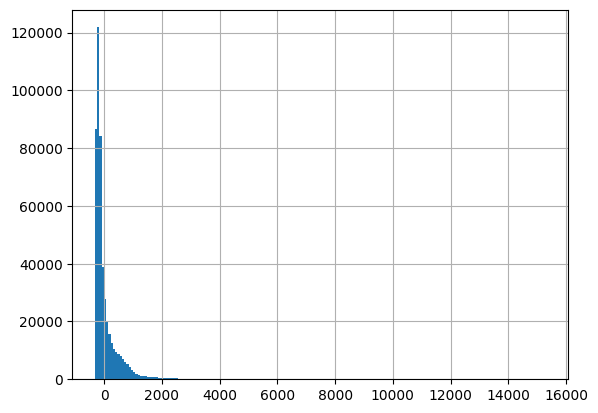

In [268]:
testDf.absErr_cons.hist(bins=200)

In [45]:
testDf.absErr_prod.hist(bins=200)

AttributeError: 'DataFrame' object has no attribute 'absErr_prod'

<Axes: >

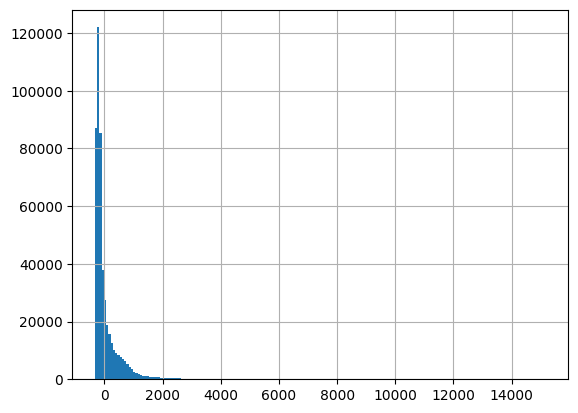

In [269]:
trainDf.absErr_cons.hist(bins=200)

In [47]:
trainDf.absErr_prod.hist(bins=200)

AttributeError: 'DataFrame' object has no attribute 'absErr_prod'

### investigate consumption
- some heavy overestimation (when no consumption but we predict one)
- some heave underestimation, when lots of consumption but no prediciton

we can't fit yearly trend!!
things that don't help:
- relu activation function doesn't help (but makes targets all positive)
- input normalization
- target normalization
- bigger network
- using less features to predict
- using weights on day doesn't help (but is definitely needed)


it seems that the consumption data is very sparse & hence really hard to fit 
-> try to find a normalization criteria


In [15]:
print(testDf.y_cons.mean(),testDf.y_cons.std())
print(testDf.pred_cons.mean(),testDf.pred_cons.std())

448.0924781740108 1160.7522678616065
427.09658822193745 66.6903775700958


In [16]:
print(trainDf.y_cons.std()/trainDf.y_cons.mean())
print(trainDf.pred_cons.std()/trainDf.pred_cons.mean())

2.603204876948509
0.1561479416435328


In [17]:
trainDf['normCons'] = trainDf['y_cons'] / trainDf['installed_capacity']
print(trainDf.normCons.std()/trainDf.normCons.mean())

1.6454118861686216


/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_36605/1851752142.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='hours_ahead'>

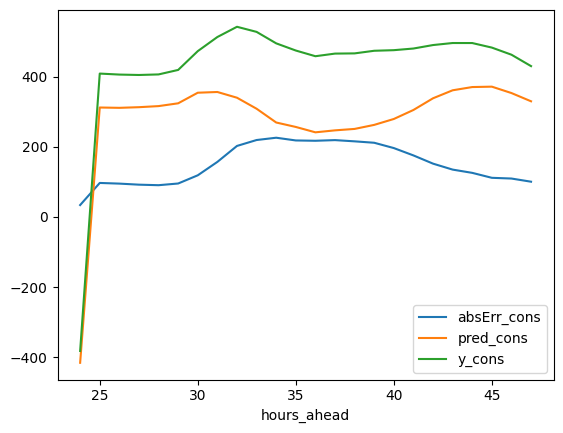

In [41]:
trainDf.groupby('hours_ahead')[['absErr_cons','pred_cons','y_cons']].mean().plot()

<Axes: xlabel='hours_ahead'>

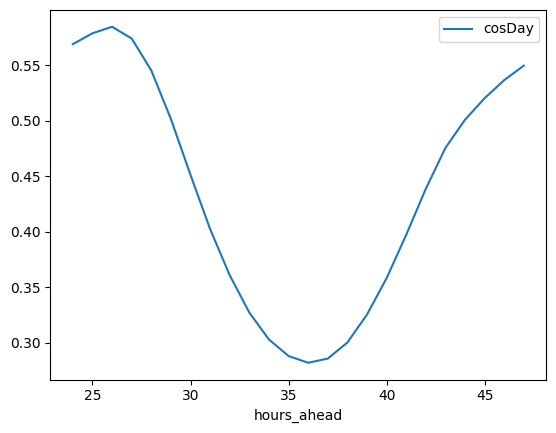

In [103]:
trainDf.groupby('hours_ahead')[['cosDay']].mean().plot()

<Axes: xlabel='unique_time'>

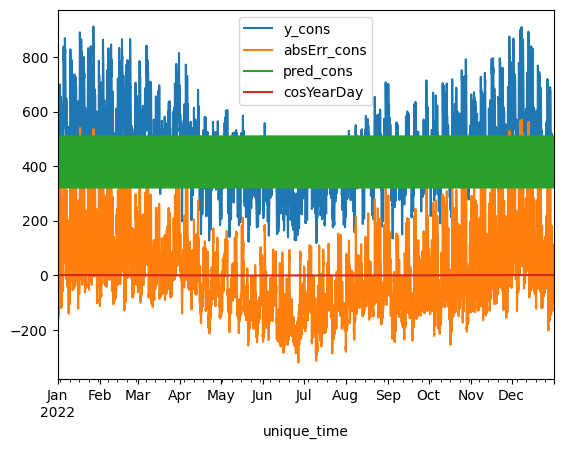

In [18]:
trainDf.groupby('unique_time')[['y_cons','absErr_cons','pred_cons','cosYearDay']].mean().plot()
#trainDf.groupby('unique_time')[['pred_cons']].mean().plot()

In [27]:
trainDf.columns

Index(['y_cons', 'y_prod', 'isTrain', 'data_block_id', 'county', 'is_business',
       'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity',
       'business_prodType', 'ind_customer_id', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'yearday', 'weekday', 'month', 'monthday',
       'sinYearDay', 'cosYearDay', 'ePrices', 'hours_ahead', 'temperatureint',
       'dewpointint', 'total_precipitationint', 'sinDay', 'cosDay',
       'temperatureint', 'windspeed_10mint', 'unique_time', 'pred_cons',
       'absErr_cons', 'normCons'],
      dtype='object')

mean              y_cons
county             
0.0     1658.080610
1.0       47.776527
2.0      231.837510
3.0      264.130209
4.0      252.932575
5.0      383.474598
6.0      173.806255
7.0      322.675802
8.0      120.289284
9.0      123.198241
10.0     312.296198
11.0     898.716060
12.0     546.231824
13.0     139.191691
14.0     441.239258
15.0     188.280639 std              y_cons
county             
0.0     2853.042438
1.0       38.941096
2.0      461.812443
3.0      386.267123
4.0      303.749485
5.0      470.907821
6.0      116.565949
7.0      327.486305
8.0      141.772519
9.0      122.637710
10.0     452.410214
11.0    1680.716920
12.0     189.507541
13.0     269.779320
14.0     678.212242
15.0     204.600841
mean                  y_cons
is_business            
0.0          133.353910
1.0          751.978043 std                   y_cons
is_business             
0.0           308.541244
1.0          1572.464903
mean                   y_cons
product_type            
0.0        

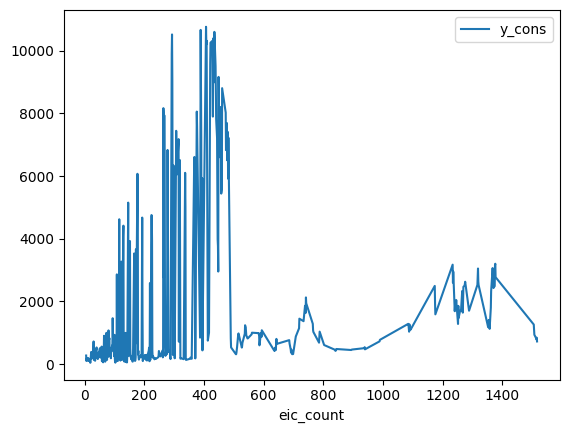

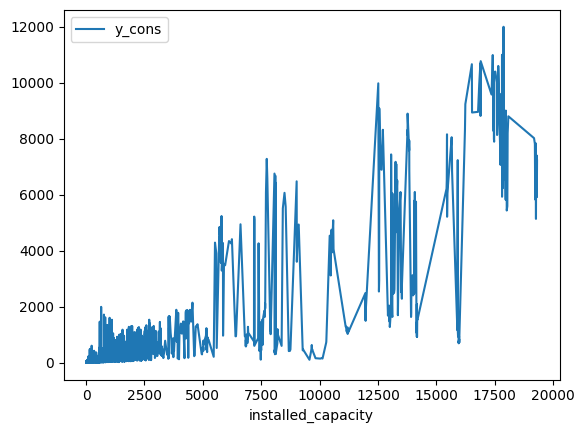

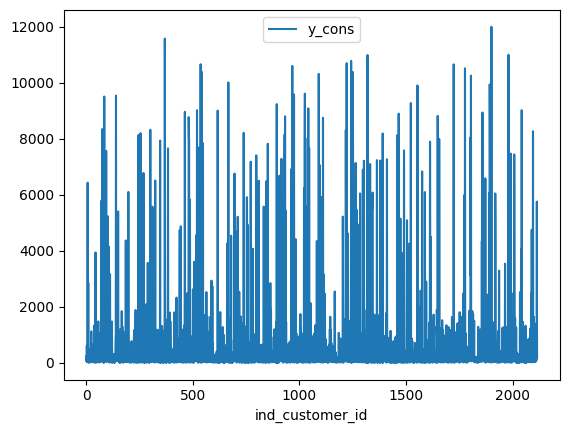

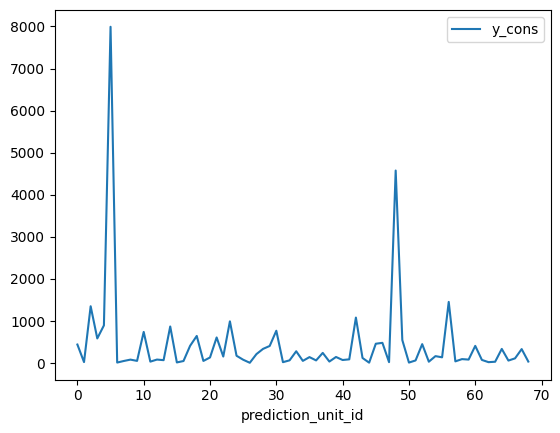

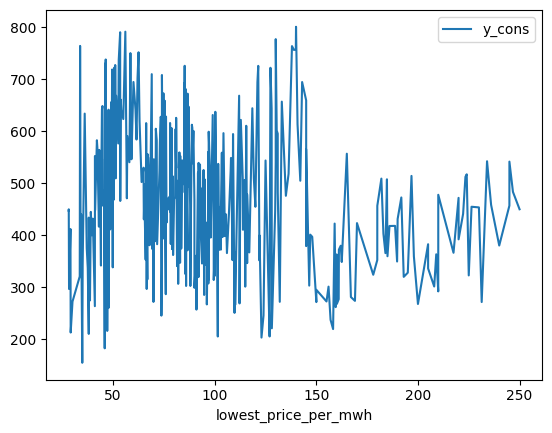

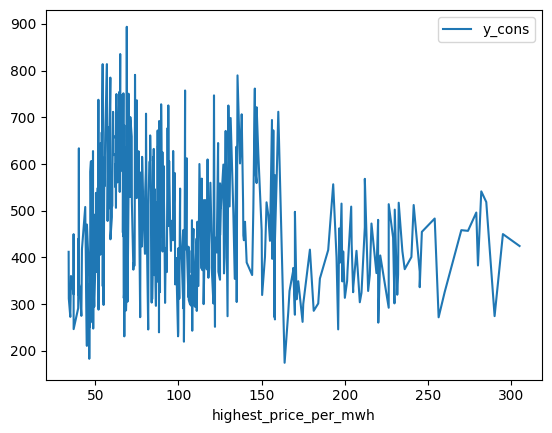

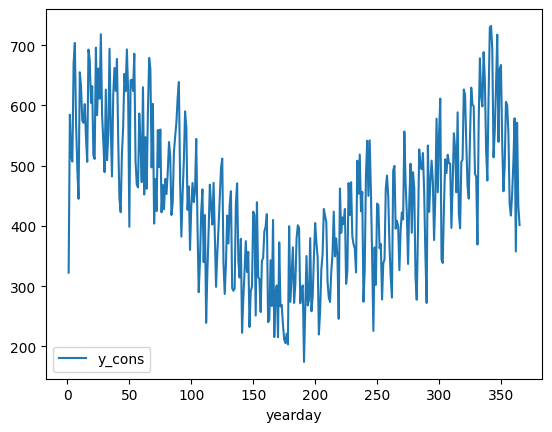

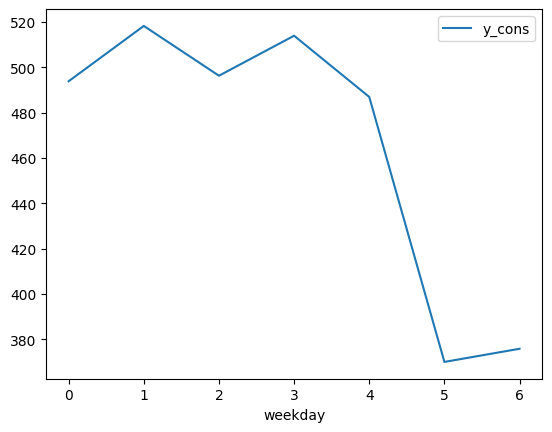

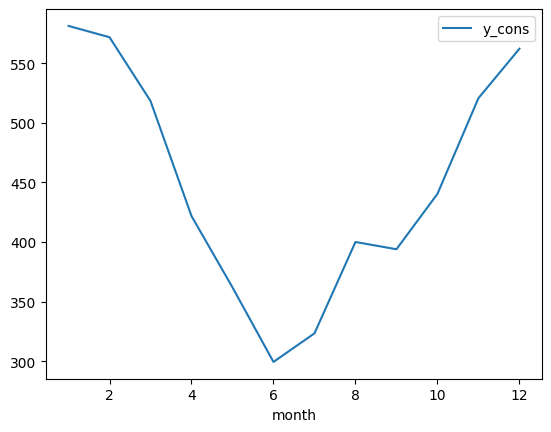

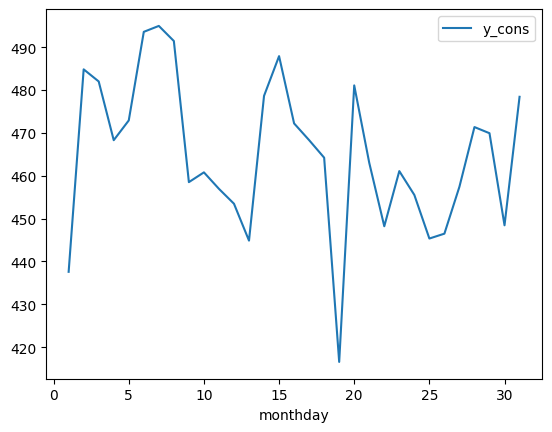

In [56]:
for f in ['county', 'is_business',
       'product_type', 
       'business_prodType'
]:
       print('mean', trainDf.groupby(f)[['y_cons']].mean(),'std', trainDf.groupby(f)[['y_cons']].std())
       #print()

for f in ['eic_count', 'installed_capacity','ind_customer_id', 'prediction_unit_id', 
       'lowest_price_per_mwh','highest_price_per_mwh', 
       'yearday', 'weekday', 'month', 'monthday',
]:
       trainDf.groupby(f)[['y_cons']].mean().plot()

In [44]:
testDf['normCons'] = testDf['y_cons'] / testDf['windspeed_10mint']
testDf['normConsProd'] = testDf['pred_cons'] / testDf['installed_capacity']
testDf = testDf.sort_values(by='unique_time')
a = testDf.loc[(testDf.yearday >0) & (testDf.yearday < 180)]

fig = subplots.make_subplots(rows=1, cols=1,shared_xaxes=True)

#fig.add_trace(go.Scatter(x = a['unique_time'], y = a['y_cons'],mode ='markers', name='y_cons'),row=1, col=1)
#fig.add_trace(go.Scatter(x = a['unique_time'], y = a['pred_cons'],mode ='markers', name='pred_cons'),row=1, col=1)
fig.add_trace(go.Scatter(x = a['unique_time'], y = a['normCons'],mode ='markers', name='normCons'),row=1, col=1)
#fig.add_trace(go.Scatter(x = a['unique_time'], y = a['normConsProd'],mode ='markers', name='normConsProd'),row=1, col=1)
fig.show()


<Axes: xlabel='hours_ahead'>

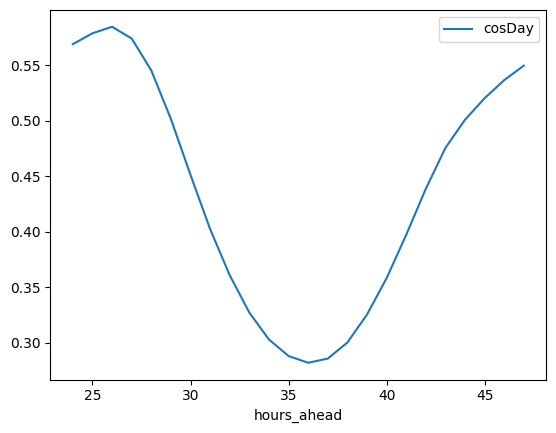

In [ ]:
trainDf.groupby('hours_ahead')[['cosDay']].mean().plot()

In [67]:
del fig

In [274]:
pd.set_option('Display.max_columns', None)
pd.set_option('Display.max_rows', None)
cond = (testDf.data_block_id == 469) & (testDf.prediction_unit_id == 5) & (testDf.county == 0)
cond = (testDf.data_block_id == 495) & (testDf.prediction_unit_id == 21) & (testDf.county == 5)
testDf.loc[cond]

#pd.set_option('Display.max_columns', 10)
#pd.set_option('Display.max_rows', 10)


y_cons  y_prod  isTrain  data_block_id  county  is_business  \
527040  177.00     0.0      0.0          495.0     5.0          1.0   
527041  169.25     0.0      0.0          495.0     5.0          1.0   
527042  126.40     0.0      0.0          495.0     5.0          1.0   
527043  170.37     0.0      0.0          495.0     5.0          1.0   
527044  242.11     0.0      0.0          495.0     5.0          1.0   
527045  266.68     0.0      0.0          495.0     5.0          1.0   
527046  264.38     0.0      0.0          495.0     5.0          1.0   
527047  365.46     0.0      0.0          495.0     5.0          1.0   
527048  383.20     0.0      0.0          495.0     5.0          1.0   
527049  342.70     0.0      0.0          495.0     5.0          1.0   
527050  347.07     0.0      0.0          495.0     5.0          1.0   
527051  380.66     0.0      0.0          495.0     5.0          1.0   
527052  417.37     0.0      0.0          495.0     5.0          1.0   
527053  375.99     0.1      0.0          495.0     5.0          1.0   
527054  358.04     0.0      0.0          495.0     5.0          1.0   
527055  338.89     0.0      0.0          495.0     5.0          1.0   
527056  293.16     0.0      0.0          495.0     5.0          1.0   
527057  236.51     0.0      0.0          495.0     5.0          1.0   
527058  256.77     0.0      0.0          495.0     5.0          1.0   
527059  250.56     0.0      0.0          495.0     5.0          1.0   
527060  253.98     0.0      0.0          495.0     5.0          1.0   
527061  231.57     0.0      0.0          495.0     5.0          1.0   
527062  218.03     0.0      0.0          495.0     5.0          1.0   
527063  205.90     0.0      0.0          495.0     5.0          1.0   

        product_type  prediction_unit_id  eic_count  installed_capacity  \
527040           0.0                21.0        9.0               505.6   
527041           0.0                21.0        9.0               505.6   
527042           0.0                21.0        9.0               505.6   
527043           0.0                21.0        9.0               505.6   
527044           0.0                21.0        9.0               505.6   
527045           0.0                21.0        9.0               505.6   
527046           0.0                21.0        9.0               505.6   
527047           0.0                21.0        9.0               505.6   
527048           0.0                21.0        9.0               505.6   
527049           0.0                21.0        9.0               505.6   
527050           0.0                21.0        9.0               505.6   
527051           0.0                21.0        9.0               505.6   
527052           0.0                21.0        9.0               505.6   
527053           0.0                21.0        9.0               505.6   
527054           0.0                21.0        9.0               505.6   
527055           0.0                21.0        9.0               505.6   
527056           0.0                21.0        9.0               505.6   
527057           0.0                21.0        9.0               505.6   
527058           0.0                21.0        9.0               505.6   
527059           0.0                21.0        9.0               505.6   
527060           0.0                21.0        9.0               505.6   
527061           0.0                21.0        9.0               505.6   
527062           0.0                21.0        9.0               505.6   
527063           0.0                21.0        9.0               505.6   

        business_prodType  ind_customer_id  lowest_price_per_mwh  \
527040                5.0            599.0                  76.0   
527041                5.0            599.0                  76.0   
527042                5.0            599.0                  76.0   
527043                5.0            599.0                  76.0   
527044          

<Axes: xlabel='data_block_id'>

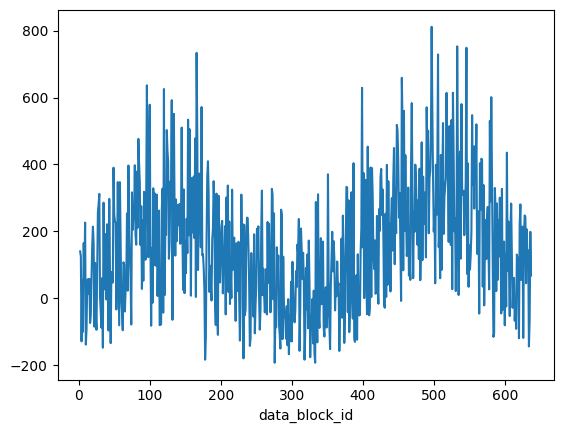

In [134]:
testDf.groupby('data_block_id')['absErr_cons'].mean().plot() 

In [217]:
testDf.loc[testDf.absErr_cons < -140].y_cons.mean()

57.601196242992785

# investigate business_prodType

0.0
   is_business  product_type
0          0.0           1.0
3.0
    is_business  product_type
24          0.0           3.0
6.0
    is_business  product_type
48          1.0           3.0
2.0
     is_business  product_type
144          1.0           1.0
4.0
     is_business  product_type
336          0.0           2.0
1.0
     is_business  product_type
528          1.0           2.0
5.0
     is_business  product_type
648          1.0           0.0


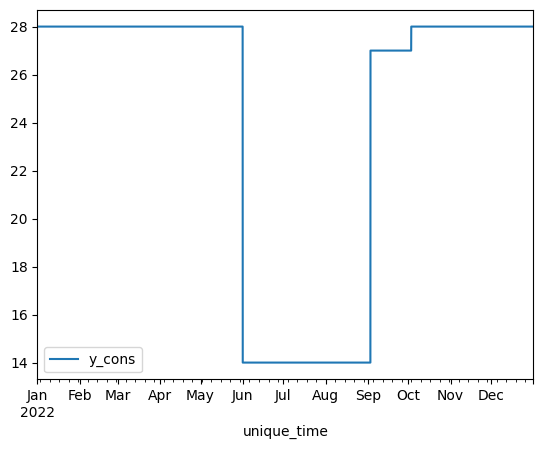

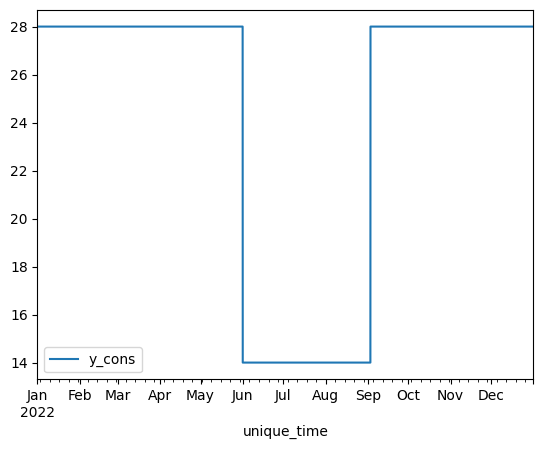

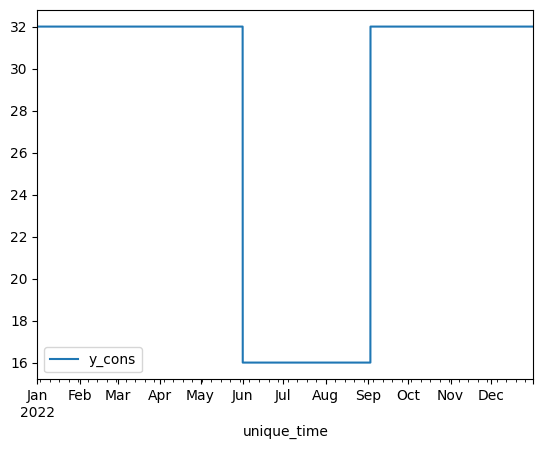

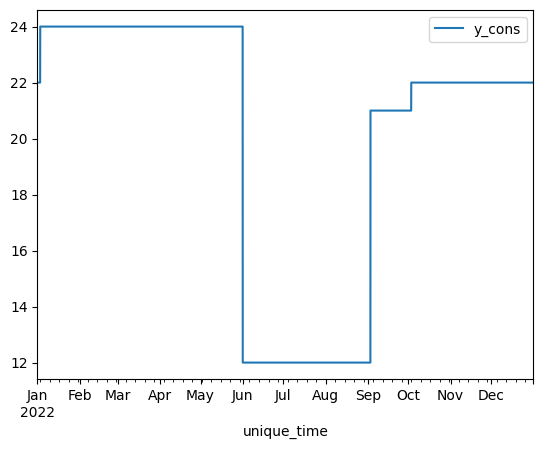

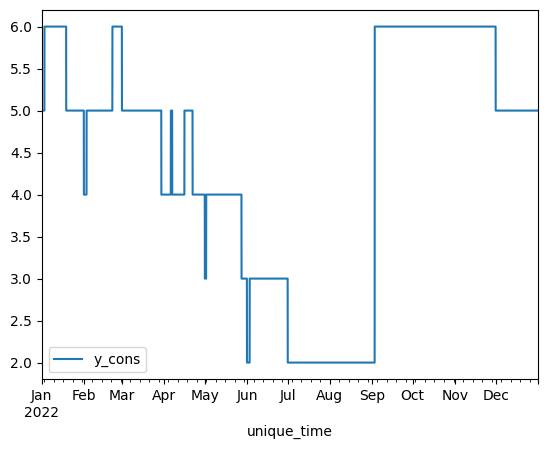

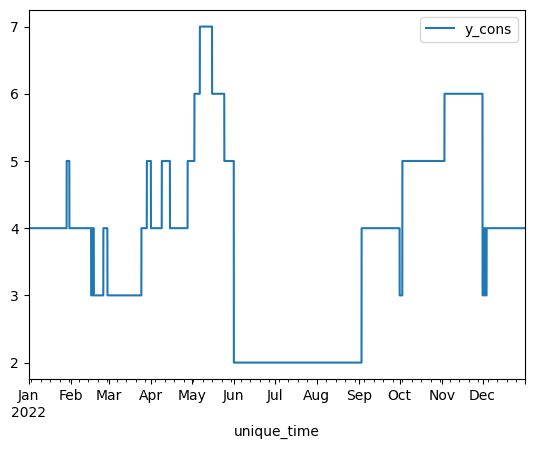

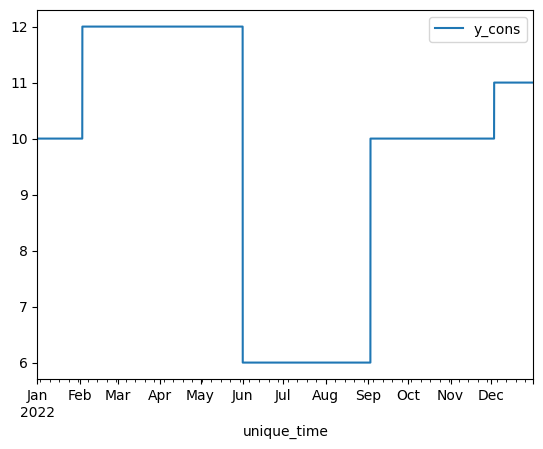

In [68]:
# 2& 3 similar, 5 as well, but a bit bigger on average
for id in appendedDf.business_prodType.unique():
    print(id)
    appendedDf.loc[appendedDf.business_prodType == id].groupby('unique_time')[['y_cons']].count().plot()
    print(appendedDf.loc[appendedDf.business_prodType == id][['is_business','product_type']].head(1))